In [16]:
import h2o
h2o.init(strict_version_check=False) # give h2o as much memory as possible
h2o.remove_all()
h2o.no_progress() # turn off h2o progress bars


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,3 days 22 hours 5 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,"14 days, 11 hours and 6 minutes"
H2O cluster name:,H2O_from_python_qinhuixu_4r2cn5
H2O cluster total nodes:,1
H2O cluster free memory:,1.723 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

# Import Data

In [18]:
train = h2o.import_file('/Users/qinhuixu/Desktop/Kaggle/RussianHousing/xqh/data/train.csv')
test = h2o.import_file('/Users/qinhuixu/Desktop/Kaggle/RussianHousing/xqh/data/test.csv')

In [19]:
y_train = train["price_doc"] * .968 + 10.
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

In [20]:
y_train

price_doc
5.66281e+06
5.80801e+06
5.51761e+06
1.26808e+07
1.58089e+07
8.80881e+06
5.32401e+06
1.93601e+06
5.13041e+06
1.93601e+06


### Determine Data Types

In [21]:
def get_type_lists(frame=train, rejects=['id','timestamp','price_doc']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [22]:
original_nums, cats = get_type_lists()

Numeric = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_

In [23]:
train["price_doc"]

price_doc
5.85e+06
6e+06
5.7e+06
1.31e+07
1.63315e+07
9.1e+06
5.5e+06
2e+06
5.3e+06
2e+06


# Encode categorical using shrunken averages

In [24]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):
    
    """ Applies simple target encoding to categorical variables.
    
    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames. 
    
    """
    
    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series

    
    # create dictionary of level:encode val
    
    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)
                
    row_val_dict[np.nan] = overall_mean # handle missing values
    
    if test:
        print(row_val_dict)
        
    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])   
    
    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])
    
    # convert back to H2O
    
    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]
    
    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]
    
    return (trdf, tsdf)

### Execute Encoding

In [25]:
for i, var in enumerate(cats):
    
    total = len(cats)
    tr_enc, ts_enc = target_encoder(train, test, var, 'price_doc')

    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: product_type (1/15) ...
Encoding: sub_area (2/15) ...
Encoding: culture_objects_top_25 (3/15) ...
Encoding: thermal_power_plant_raion (4/15) ...
Encoding: incineration_raion (5/15) ...
Encoding: oil_chemistry_raion (6/15) ...
Encoding: radiation_raion (7/15) ...
Encoding: railroad_terminal_raion (8/15) ...
Encoding: big_market_raion (9/15) ...
Encoding: nuclear_reactor_raion (10/15) ...
Encoding: detention_facility_raion (11/15) ...
Encoding: water_1line (12/15) ...
Encoding: big_road1_1line (13/15) ...
Encoding: railroad_1line (14/15) ...
Encoding: ecology (15/15) ...
Done.


#### Redefine numerics and explore

In [26]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_

In [27]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:30471
Cols:289




,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_coun

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:7662
Cols:289




,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_coun

# Create combination features

In [ ]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame

In [ ]:
#train, test = feature_combiner(train, test, encoded_nums)

#### Redefine numerics and explore

In [ ]:
encoded_combined_nums, cats = get_type_lists(frame=train)

# Train constituent models (for inspection purposes)

In [28]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator


# Check log transform - looks good
%matplotlib inline
train['price_doc'].log().as_data_frame().hist()

# Execute log transform
train['price_doc'] = train['price_doc'].log()
print(train[0:3, 'price_doc'])

In [29]:
train["price_doc"] = train["price_doc"] * .968 + 10.
train = train.drop(["id", "timestamp"], axis=1)
test = test.drop(["id", "timestamp"], axis=1)

### Spliting Training Data

In [30]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(21382, 305)
(9089, 305)


### Define model with grid search function

In [31]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid,
               nfolds = 5,
               fold_assignment = "Modulo",
               keep_cross_validation_predictions = True)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

In [73]:
def gbm_grid (X, y, train, valid):
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2O Graident Boosting Model

    """
    from h2o.estimators.gbm import H2OGradientBoostingEstimator
    from h2o.grid import H2OGridSearch
    # GBM with random hyperparameter search
    # train many different GBM models with random hyperparameters
    # and select best model based on validation error

    # define random grid search parameters
    hyper_parameters = {'ntrees':list(range(0, 500, 50)),
                        'max_depth':list(range(0, 20, 2)),
                        'sample_rate':[s/float(10) for s in range(1, 11)],
                        'col_sample_rate':[s/float(10) for s in range(1, 11)]}

    # define search strategy
    search_criteria = {'strategy':'RandomDiscrete',
                       'max_models':20,
                       'max_runtime_secs':600}

    # initialize grid search
    gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                            hyper_params=hyper_parameters,
                            search_criteria=search_criteria)
    #X = encoded_nums
    #y = "price_doc"

    # execute training w/ grid search
    gsearch.train(x=X,
                  y=y,
                  training_frame=train,
                  validation_frame=valid,
                  nfolds = 5,
                  fold_assignment = "Modulo",
                  keep_cross_validation_predictions = True)
     # show grid search results
    print(gsearch.show())

    best = gsearch.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

In [62]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid import H2OGridSearch
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(0, 500, 50)),
                    'max_depth':list(range(0, 20, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)
#X = encoded_nums
#y = "price_doc"

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [63]:

# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model


    col_sample_rate max_depth ntrees sample_rate  \
0               0.6         4    350         0.6   
1               0.4         8    200         0.6   
2               0.6         4    350         0.3   
3               0.4         4    100         1.0   
4               0.3         8    250         0.6   
5               0.9         2    450         0.9   
6               0.4        14    300         0.8   
7               0.2         2    450         0.8   
8               1.0        16    400         0.6   

                                                        model_ids  \
0  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_27_model_3   
1  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_27_model_8   
2  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_27_model_2   
3  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_27_model_0   
4  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_27_model_6   
5  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_27_model_7

,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-05 02:51:42,3 min 30.043 sec,0.0,4730405.4347707,2834637.9286755,22376735577307.9921875,4374547.2089876,2768384.1192242,19136663283660.9765625
,2017-06-05 02:51:42,3 min 30.281 sec,1.0,4480881.1249123,2690542.7395166,20078295655595.3515625,4135065.2937039,2626422.9327237,17098764983194.8808594
,2017-06-05 02:51:43,3 min 30.489 sec,2.0,4265637.7696954,2554173.9293258,18195665582251.6289062,3931236.3012344,2491024.2617870,15454618856142.7519531
,2017-06-05 02:51:43,3 min 30.736 sec,3.0,4070569.9593671,2414759.4298402,16569539794101.8945312,3750408.8986390,2357636.6074576,14065566906990.5917969
,2017-06-05 02:51:43,3 min 30.921 sec,4.0,3898411.7333849,2307953.6742514,15197614042993.4082031,3588557.0262245,2255257.4463160,12877741530465.2460938
---,---,---,---,---,---,---,---,---,---
,2017-06-05 02:52:34,4 min 22.200 sec,244.0,2113521.9220847,1257494.8364556,4466974915132.6591797,2431064.0493944,1372041.7007854,5910072412257.7431641
,2017-06-05 02:52:39,4 min 26.817 sec,269.0,2084632.4875113,1246469.8178535,4345692607987.3540039,2425829.7260244,1370259.7790561,5884649859663.7333984
,2017-06-05 02:52:44,4 min 32.254 sec,300.0,2051017.2281873,1231395.9082567,4206671670321.0634766,2429360.0631862,1368737.4034050,5901790316604.2119141
,2017-06-05 02:52:49,4 min 37.317 sec,325.0,2027117.9791330,1221602.9679272,4109207301324.2583008,2425964.0890989,1368682.8628370,5885301761597.5957031



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
full_sq,685058484986707968.0000000,1.0,0.4050335
sub_area_Tencode,184421463283990528.0000000,0.2692054,0.1090372
num_room,150376580378525696.0000000,0.2195091,0.0889086
life_sq,29814771763118080.0000000,0.0435215,0.0176277
cafe_count_3000_price_2500,27697183234981888.0000000,0.0404304,0.0163757
---,---,---,---
incineration_raion_Tencode,0.0,0.0,0.0
oil_chemistry_raion_Tencode,0.0,0.0,0.0
radiation_raion_Tencode,0.0,0.0,0.0
railroad_terminal_raion_Tencode,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [68]:
def rmf_grid (X, y, train, valid):
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2O Random Forest Model

    """
    ## Hyper-Parameter Search
    from h2o.estimators.random_forest import H2ORandomForestEstimator
    from h2o.grid import H2OGridSearch

    # define random grid search parameters
    hyper_parameters = {'ntrees':list(range(0, 500, 50)),
                        'max_depth':list(range(0, 20, 2)),
                        'sample_rate':[s/float(10) for s in range(1, 11)]}

    # define search strategy
    search_criteria = {'strategy':'RandomDiscrete',
                       'max_models':20,
                       'max_runtime_secs':600}

    grid = H2OGridSearch(H2ORandomForestEstimator, hyper_parameters, search_criteria=search_criteria)
    grid.train(x=X, 
               y=y, 
               training_frame=train,
               validation_frame=valid,
               nfolds = 5,
               fold_assignment = "Modulo",
               keep_cross_validation_predictions = True)
     # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

# Train base level models

### First  GLM model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                       model_ids  \
0    [0.25]  Grid_GLM_py_134_sid_a21a_model_python_1496289486384_19_model_1   
1    [0.01]  Grid_GLM_py_134_sid_a21a_model_python_1496289486384_19_model_0   
2     [0.5]  Grid_GLM_py_134_sid_a21a_model_python_1496289486384_19_model_2   
3    [0.99]  Grid_GLM_py_134_sid_a21a_model_python_1496289486384_19_model_3   

       residual_deviance  
0  4.7845936011399949E17  
1  4.7845936011399949E17  
2  4.7845936011399949E17  
3  4.7845936011399949E17  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_134_sid_a21a_model_python_1496289486384_19_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 22376735577307.992
RMSE: 4730405.434770681
MAE: 2834637.9286755137
RMSLE: 0.6299082597200081
R^2: -5.81756864903582e-14
Mean Residual Deviance: 22376735577307.992
N

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2813414.8,56642.71,2807834.2,2724342.5,2904414.8,2726271.0,2904210.8
mse,22139241500000.0000000,2454044540000.0000000,21536780100000.0000000,17621818800000.0000000,24660693500000.0000000,19583616400000.0000000,27293302900000.0000000
null_deviance,95719840000000000.0000000,10584828800000000.0000000,92222474000000000.0000000,76508563000000000.0000000,106736861000000000.0000000,84992172000000000.0000000,118139114000000000.0000000
r2,0.0102139,0.0033648,0.0010435,0.0135861,0.0115005,0.0141898,0.0107495
residual_deviance,94675227000000000.0000000,10489723200000000.0000000,92112806000000000.0000000,75368524000000000.0000000,105449118000000000.0000000,83739544000000000.0000000,116706158000000000.0000000
rmse,4690840.0,260061.12,4640773.5,4197835.0,4965953.5,4425338.0,5224299.0
rmsle,0.6285401,0.0025097,NaN,0.6286179,0.6243859,0.6330500,0.6281065


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2017-06-04 22:17:13,0.000 sec,0,.79E7,2,22376735827850.5976562,19136663536547.0859375,22379758948505.5781250,1752066199209.5925293
,2017-06-04 22:17:13,0.036 sec,0,.72E7,2,22376735672772.4414062,19136663390398.8242188,22379758906821.1757812,1752066167991.1430664
,2017-06-04 22:17:13,0.072 sec,0,.66E7,2,22376735502574.3828125,19136663230001.2851562,22383523704721.2304688,1751030036618.1613770



glm prediction progress: |████████████████████████████████████████████████| 100%


price_doc,predict
1.26808e+07,6.91706e+06
1.93601e+06,6.91706e+06
1.93601e+06,6.91706e+06
1.79081e+06,6.91706e+06
6.09841e+06,6.91706e+06
7.64721e+06,6.91706e+06
5.03361e+06,6.91706e+06
5.71121e+06,6.91706e+06
1.77144e+07,6.91706e+06
5.51761e+06,6.91706e+06


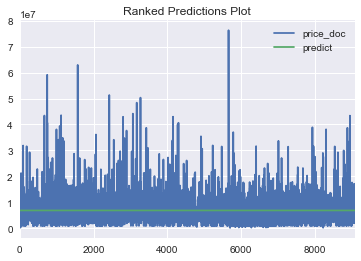

In [34]:
#glm_base1 = glm_grid(encoded_nums, 'price_doc', train, valid)

### Second model on encoded numeric inputs

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate max_depth ntrees sample_rate  \
0               1.0        18     62         0.9   
1               0.1         4     56         0.7   
2               0.7        10      0         0.9   
3               0.6        16      0         0.7   
4               0.5        14      0         0.5   

                                                        model_ids  \
0  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_32_model_1   
1  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_32_model_5   
2  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_32_model_4   
3  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_32_model_2   
4  Grid_GBM_py_134_sid_a21a_model_python_1496289486384_32_model_0   

       residual_deviance  
0   7.581012817903972E12  
1   8.457322568689442E12  
2  2.2383274885510727E13  
3  2.2383274885510727E13  
4  2.2383274885510727E13  
None
Model Details
H2OGradien

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1407440.2,22437.092,1380342.1,1383115.9,1418501.2,1390396.1,1464845.8
mse,7581061300000.0000000,790395680000.0000000,7047432100000.0000000,7081932900000.0000000,7303691000000.0000000,6690451200000.0000000,9781798500000.0000000
r2,0.6585196,0.0240791,0.6731137,0.6035757,0.7072387,0.6632126,0.6454570
residual_deviance,7581061300000.0000000,790395680000.0000000,7047432100000.0000000,7081932900000.0000000,7303691000000.0000000,6690451200000.0000000,9781798500000.0000000
rmse,2746520.2,137272.02,2654700.0,2661190.0,2702534.2,2586590.5,3127586.8
rmsle,0.4750802,0.0100756,0.4567083,0.4845509,0.4597474,0.4926385,0.4817560


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-05 03:38:50,8 min 23.375 sec,0.0,4730405.4347707,2834637.9286755,22376735577307.9921875,4374547.2089876,2768384.1192242,19136663283660.9765625
,2017-06-05 03:38:51,8 min 24.636 sec,1.0,4369517.2428974,2609415.9591406,19092680935977.5781250,4078521.2743544,2574364.2075570,16634335785361.5507812
,2017-06-05 03:38:52,8 min 25.900 sec,2.0,4047236.4487165,2404892.5440017,16380122871819.3593750,3817703.2754373,2402912.1722928,14574858299285.0683594
,2017-06-05 03:38:57,8 min 30.536 sec,5.0,3266419.4931117,1907252.5277497,10669496304979.8300781,3244172.1374451,2005577.9864210,10524652857375.0156250
,2017-06-05 03:39:02,8 min 35.490 sec,9.0,2547186.2546110,1446792.2831982,6488157815679.0244141,2815051.6411623,1683245.9306727,7924515742410.6748047
,2017-06-05 03:39:06,8 min 39.890 sec,13.0,2082605.4674471,1146272.1221749,4337245533040.4731445,2629811.8143791,1512831.6636885,6915910179048.0429688
,2017-06-05 03:39:11,8 min 44.768 sec,18.0,1727688.1307372,917048.9742234,2984906277090.3339844,2546750.7797570,1409578.9062049,6485939534193.0732422
,2017-06-05 03:39:16,8 min 49.561 sec,23.0,1493076.3247757,773296.1674583,2229276911605.6176758,2515653.5620710,1369084.2538024,6328512844360.2880859
,2017-06-05 03:39:20,8 min 54.173 sec,28.0,1332404.8933387,683556.7399141,1775302799792.7895508,2507835.2267937,1354314.1533235,6289237524747.4531250
,2017-06-05 03:39:25,8 min 58.691 sec,33.0,1211058.9381311,620868.0778502,1466663751627.1567383,2506056.7017159,1350770.1779366,6280320192215.0029297


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
full_sq,978173922581151744.0000000,1.0,0.4238454
cafe_count_3000_price_2500,127470815414321152.0000000,0.1303151,0.0552334
cafe_count_3000,108288976074309632.0000000,0.1107052,0.0469219
sport_count_2000,37427006442307584.0000000,0.0382621,0.0162172
cafe_count_2000,31432142630158336.0000000,0.0321335,0.0136196
---,---,---,---
0_13_male,3208421834752.0000000,0.0000033,0.0000014
metro_km_walk,732999712768.0000000,0.0000007,0.0000003
railroad_station_walk_min,61365862400.0000000,0.0000001,0.0000000
0_6_all,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


price_doc,predict
1.26808e+07,1.09318e+07
1.93601e+06,5.51239e+06
1.93601e+06,5.75359e+06
1.79081e+06,7.05982e+06
6.09841e+06,5.0796e+06
7.64721e+06,6.30268e+06
5.03361e+06,5.86016e+06
5.71121e+06,4.43431e+06
1.77144e+07,1.06553e+07
5.51761e+06,5.04782e+06


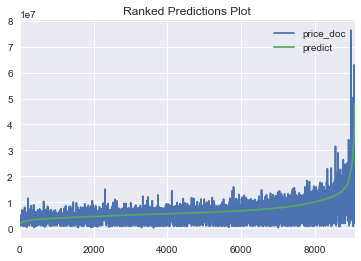

In [74]:
gbm_base2 = gbm_grid(original_nums, 'price_doc', train, valid)

In [47]:
train.shape

(21382, 305)

In [48]:
train["price_doc"]

price_doc
5.66281e+06
5.80801e+06
5.51761e+06
1.58089e+07
8.80881e+06
5.32401e+06
5.13041e+06
4.50121e+06
4.64641e+06
4.93681e+06


drf Grid Build progress: |████████████████████████████████████████████████| 100%
    max_depth ntrees sample_rate  \
0          16     29         0.9   
1           8      1         0.7   
2           2    450         0.4   

                                                        model_ids  \
0  Grid_DRF_py_134_sid_a21a_model_python_1496289486384_29_model_1   
1  Grid_DRF_py_134_sid_a21a_model_python_1496289486384_29_model_2   
2  Grid_DRF_py_134_sid_a21a_model_python_1496289486384_29_model_0   

       residual_deviance  
0   7.771805821029601E12  
1   1.104658714756256E13  
2  1.3236540527819473E13  
None
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_py_134_sid_a21a_model_python_1496289486384_29_model_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 9897932074837.973
RMSE: 3146097.912468392
MAE: 1592747.9586109624
RMSLE: 0.5155243470052072
Mean Residual Deviance: 9897932074837.973

ModelMetricsRegression: drf
** Reported 

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1417038.1,24782.594,1364770.6,1407738.0,1426840.9,1412200.5,1473641.0
mse,7771873900000.0000000,827085290000.0000000,6723970000000.0000000,7361461200000.0000000,7801444800000.0000000,6977501000000.0000000,9994992900000.0000000
r2,0.6499651,0.0261690,0.6881171,0.5879286,0.6872868,0.6487629,0.6377297
residual_deviance,7771873900000.0000000,827085290000.0000000,6723970000000.0000000,7361461200000.0000000,7801444800000.0000000,6977501000000.0000000,9994992900000.0000000
rmse,2780470.2,142931.25,2593061.8,2713201.2,2793106.8,2641496.0,3161485.8
rmsle,0.4750491,0.0102247,0.4555563,0.4858411,0.4608476,0.4930221,0.4799787


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-05 03:26:44,8 min 57.291 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-05 03:26:46,8 min 59.245 sec,1.0,3428599.4083627,1734295.5815805,11755293903025.0917969,3510478.0400113,1765267.7066853,12323456069401.3593750
,2017-06-05 03:26:48,9 min 0.986 sec,2.0,3396352.7079749,1770604.6561886,11535211716968.3183594,2859874.0361189,1544154.6780036,8178879502466.7636719
,2017-06-05 03:26:52,9 min 5.073 sec,4.0,3647711.4944021,1768919.9123022,13305799146392.9414062,2708830.1783367,1466679.8995300,7337760935067.7353516
,2017-06-05 03:26:56,9 min 9.342 sec,6.0,3565442.5341171,1744458.1061040,12712380464091.4960938,2661197.8385555,1427056.5928532,7081973935932.3574219
,2017-06-05 03:27:01,9 min 13.955 sec,8.0,3591498.8643313,1755273.2833126,12898864092493.2597656,2641454.4294828,1413570.9159118,6977281503034.1894531
,2017-06-05 03:27:05,9 min 18.037 sec,10.0,3730159.7371434,1755924.5927201,13914091664605.6445312,2613744.0231559,1397553.2252025,6831657818583.1259766
,2017-06-05 03:27:11,9 min 24.317 sec,13.0,3529458.9073459,1724511.3412904,12457080178643.0039062,2569332.4936938,1384894.9929575,6601469463150.9755859
,2017-06-05 03:27:15,9 min 28.589 sec,15.0,3433591.9715360,1702973.8448800,11789553826996.1484375,2546998.9791539,1377210.8464678,6487203799810.8203125
,2017-06-05 03:27:21,9 min 34.151 sec,18.0,3351937.9635663,1675735.1508109,11235488111597.0000000,2538223.5783087,1367020.3340523,6442578933482.0097656


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
full_sq,3870718535399374848.0000000,1.0,0.3264836
num_room,855140014542028800.0000000,0.2209254,0.0721285
cafe_count_3000_price_2500,542297998315487232.0000000,0.1401027,0.0457412
life_sq,537802782464278528.0000000,0.1389413,0.0453621
cafe_count_3000,391951740406071296.0000000,0.1012607,0.0330600
---,---,---,---
0_6_all,936498090213376.0000000,0.0002419,0.0000790
mosque_count_1500,921582272774144.0000000,0.0002381,0.0000777
mosque_count_1000,917919739412480.0000000,0.0002371,0.0000774
mosque_count_2000,455070743265280.0000000,0.0001176,0.0000384



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


price_doc,predict
1.26808e+07,1.07788e+07
1.93601e+06,6.43212e+06
1.93601e+06,5.51126e+06
1.79081e+06,7.176e+06
6.09841e+06,5.5673e+06
7.64721e+06,6.6827e+06
5.03361e+06,5.68846e+06
5.71121e+06,5.31258e+06
1.77144e+07,1.02017e+07
5.51761e+06,5.18272e+06


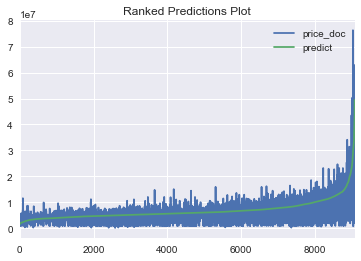

In [69]:
rmf_base3 = rmf_grid(original_nums, 'price_doc', train, valid)

### Third model on encoded numeric inputs

In [ ]:
#glm2 = glm_grid(encoded_combined_nums, 'price_doc', train, valid)

## Train combiner model

In [75]:
ensemble = H2OStackedEnsembleEstimator(base_models=list
                                       ([gbm_base2.model_id,rmf_base3.model_id]))


In [76]:
ensemble.train(training_frame=train, validation_frame=valid, x=original_nums, y='price_doc')

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [77]:
preds = ensemble.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [81]:
preds

predict
6.91622e+06
6.91761e+06
6.91633e+06
6.9167e+06
6.91609e+06
6.91837e+06
6.91571e+06
6.91568e+06
6.9157e+06
6.9159e+06
